# 11 空間構造のある階層ベイズモデル
- [空間統計モデル（CAR model）をpymc3で。（緑本11章）](https://gaiasky.hatenablog.com/entry/2018/08/15/205222)
- [PyMC3の公式ドキュメント](https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/conditional-autoregressive-model.html)

In [1]:
import requests
import zipfile
import math
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

/home/yoshino/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%matplotlib inline
%precision 3

'%.3f'

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# 全カラムを表示させる
pd.set_option('display.max_columns', None)

### 11.1 例題: 一次元空間上の個体数分布

In [5]:
file_path = './data/Y.RData'

if not os.path.isfile(file_path):
  response = requests.get('https://kuboweb.github.io/-kubo/stat/iwanamibook/fig/spatial/Y.RData')
  with open (file_path, 'wb') as f:
      f.write(response.content)
      f.close()

In [8]:
import pyreadr

data = pyreadr.read_r(file_path)
data = data['Y']
data.head()

,Y
0,0.0
1,3.0
2,2.0
3,5.0
4,6.0


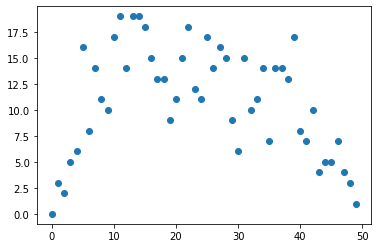

In [14]:
plt.scatter(range(len(data.Y)), data.Y)

### 空間統計モデルをデータにあてはめる

In [15]:
from pymc3.distributions import continuous, distribution

class CAR2(distribution.Continuous):
    """
    Conditional Autoregressive (CAR) distribution

    Parameters
    ----------
    a : adjacency matrix
    w : weight matrix
    tau : precision at each location
    """

    def __init__(self, w, a, tau, *args, **kwargs):
        super(CAR2, self).__init__(*args, **kwargs)
        self.a = a = tt.as_tensor_variable(a)
        self.w = w = tt.as_tensor_variable(w)
        self.tau = tau*tt.sum(w, axis=1)
        self.mode = 0.

    def logp(self, x):
        tau = self.tau
        w = self.w
        a = self.a

        mu_w = tt.sum(x*a, axis=1)/tt.sum(w, axis=1)
        return tt.sum(continuous.Normal.dist(mu=mu_w, tau=tau).logp(x))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [20]:
# 隣接情報(両隣からの影響を受けるものとする)
adj = np.array(
       [[1], [0, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7], [6, 8], [7, 9],
       [8, 10], [9, 11], [10, 12], [11, 13], [12, 14], [13, 15], [14, 16],
       [15, 17], [16, 18], [17, 19], [18, 20], [19, 21], [20, 22],
       [21, 23], [22, 24], [23, 25], [24, 26], [25, 27], [26, 28],
       [27, 29], [28, 30], [29, 31], [30, 32], [31, 33], [32, 34],
       [33, 35], [34, 36], [35, 37], [36, 38], [37, 39], [38, 40],
       [39, 41], [40, 42], [41, 43], [42, 44], [43, 45], [44, 46],
       [45, 47], [46, 48], [47, 49], [49]], dtype=object)

# 重み
weights = np.array(
       [[1.0], [1, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0],
       [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0],
       [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0],
       [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0],
       [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0],
       [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0],
       [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0],
       [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0],
       [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0],
       [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0]], dtype=object)

In [52]:
# 行列化
N = len(weights)
wmat2 = np.zeros((N,N))
amat2 = np.zeros((N,N))
for i, a in enumerate(adj):
    amat2[i,a] = 1
    wmat2[i,a] = weights[i]

In [61]:
print(wmat2.shape)
print(wmat2[1]) # 一番左から２番目の要素がどこから,どれくらい影響を受けるか? A. 両サイドだけ1になる
wmat2

(50, 50)
[1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [59]:
print(amat2.shape)
print(amat2[0]) # 一番左の要素がどこから影響を受けるか? A. 右隣だけ1になる
amat2

(50, 50)
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [58]:
amat2[0, 1]

1.000

In [31]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    # hyper
    s = pm.Uniform('s', lower=0, upper=100)
    # prior
    beta = pm.Normal('beta', mu=0, sd=10)
    tau = 1/(s*s)
    r =CAR2('r', w=wmat2, a=amat2, tau=tau, shape=N)
    #
    y = pm.Poisson('y', mu=np.exp(beta + r[np.arange(50)]), observed=data.Y)

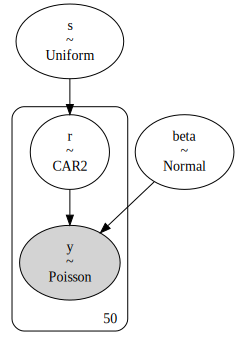

In [32]:
pm.model_to_graphviz(model)

In [33]:
%%time
with model:
    inference = pm.ADVI() # ADVI（自動微分変分法）
    approx = pm.fit(n=100000, method=inference,random_seed=123, start=pm.find_MAP(method='Powell'))
    trace = approx.sample(draws=5000)

Finished [100%]: Average Loss = 144.03


CPU times: user 20.7 s, sys: 4.86 s, total: 25.6 s
Wall time: 1min 7s


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'r'}>,
        <AxesSubplot:title={'center':'r'}>],
       [<AxesSubplot:title={'center':'s'}>,
        <AxesSubplot:title={'center':'s'}>]], dtype=object)

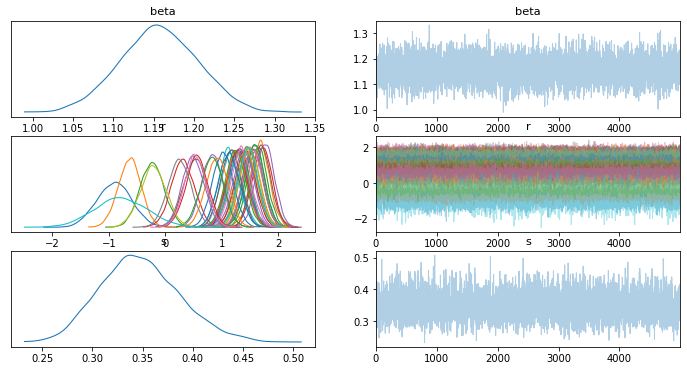

In [34]:
pm.traceplot(trace)

(-2.500, 30.000)

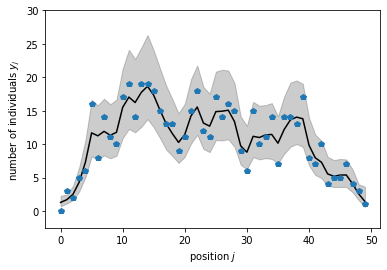

In [45]:
b = np.median(trace.get_values('beta'))
r = np.median(trace.get_values('r'),axis=0)
xx = np.arange(N)
yy = np.exp(b+r)
plt.plot(xx,yy, 'k-')
hpd = pm.hdi(trace.get_values('r'), hdi_prob=0.95)
plt.fill_between(xx, np.exp(b+hpd.T[0]), np.exp(b+hpd.T[1]), color='k', alpha=0.2)

plt.plot(range(len(data.Y)), data.Y, 'p')
plt.xlabel('position $j$')
plt.ylabel('number of individuals $y_j$')
plt.ylim(-2.5, 30)



In [46]:
pm.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,1.157,0.048,1.068,1.246,0.001,0.000,4992.0,4860.0,NaN
r[0],-0.902,0.305,-1.486,-0.352,0.004,0.003,5106.0,4976.0,NaN
r[1],-0.631,0.201,-1.010,-0.252,0.003,0.002,4931.0,4714.0,NaN
r[2],-0.234,0.214,-0.635,0.167,0.003,0.002,5087.0,5068.0,NaN
r[3],0.312,0.206,-0.074,0.700,0.003,0.002,4442.0,4667.0,NaN
r[4],0.835,0.188,0.497,1.204,0.003,0.002,4431.0,4668.0,NaN
r[5],1.299,0.179,0.951,1.627,0.003,0.002,4991.0,4754.0,NaN
r[6],1.261,0.185,0.897,1.587,0.003,0.002,5105.0,4779.0,NaN
r[7],1.322,0.178,0.998,1.668,0.003,0.002,4698.0,4672.0,NaN
r[8],1.271,0.180,0.924,1.600,0.003,0.002,4520.0,4817.0,NaN
